# <center>Artificial Neural Networks and Cognitive Models</center>

# <center>TASK - 2 Training</center>

***This notebook is only for traning with already prepared dataset. For data preparation, Please check another notebook named Data_Preparation.ipynb***

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from matplotlib import pyplot as plt
from matplotlib import pyplot as plt
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import torch.nn as nn
import torch.nn.functional as F


data = pd.read_csv(r"C:\Semester 2\ANN\Portfolio2\Prepared_datasets\training_data.csv")
data

,quizzes,solutions
0,0832954170018000590950008620700009000000700203...,6832954174218673597953418625721349868465791233...
1,1007540320002060070048390500010780000405903100...,1697548323582169472748396515314782967465923189...
2,7000508398000230409300782002798004000004970266...,7126548398659237419341782652798614533584971266...
3,0000930078030000290590824039003502016001007081...,2145936878637415297596824139783542616351297481...
4,6507300901986000070370002560003456020000010742...,6527348911986524374371982569713456823852619742...
...,...,...
49995,0896000576200001000408102060107098239020800000...,1896243576279351845438172964167598239724835613...
49996,7413090080050800402300000701000360276570481903...,7413592689657823412386149751895364276572481933...
49997,2004639101040080000800057034200070060008064919...,2574639181347986256892157434219573863758264919...
49998,9082000000024609706748000507000193800000025003...,9382571461524639786748912537256193844693825173...


# APPROACH-1 : CNN 

In [2]:
class SudokuDataset(Dataset):
    def __init__(self, dataframe, subset="train"):
        self.dataframe = dataframe
        self.subset = subset

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        puzzle = self.dataframe.iloc[idx, 0]
        solution = self.dataframe.iloc[idx, 1]

        puzzle = torch.tensor([int(p) for p in puzzle], dtype=torch.float32).reshape(1, 9, 9) / 9 - 0.5
        if self.subset == 'train':
            solution = torch.tensor([int(s) - 1 for s in solution], dtype=torch.int64).reshape(81)
            return puzzle, solution
        return puzzle

In [3]:
train_idx = int(len(data) * 0.75)
train_data = SudokuDataset(data.iloc[:train_idx], subset="train")
train_loader = DataLoader(train_data, batch_size=640, shuffle=True)

val_data = SudokuDataset(data.iloc[train_idx:], subset="train")
val_loader = DataLoader(val_data, batch_size=640, shuffle=False)

In [4]:
class SudokuSolver(nn.Module):
    def __init__(self):
        super(SudokuSolver, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout2d(0.25)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.dropout2 = nn.Dropout2d(0.25)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=1)
        self.fc1 = nn.Linear(128 * 9 * 9, 81 * 9)
        self.dropout3 = nn.Dropout(0.25)

    def forward(self, x):
        x = F.relu(self.dropout1(self.bn1(self.conv1(x))))
        x = F.relu(self.dropout2(self.bn2(self.conv2(x))))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = self.dropout3(x)
        x = self.fc1(x)
        return x.view(-1, 9)  # Reshaped to match [batch_size * 81, 9]

In [5]:
model = SudokuSolver()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
epochs = 25

In [6]:
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, dim=1)
    correct = (predicted == labels).sum().item()
    return correct / labels.size(0)

def train_model(model, train_loader, val_loader, epochs, criterion, optimizer, device):
    # Lists to store metrics
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        total_train = 0

        # Training Phase
        for puzzles, solutions in train_loader:
            puzzles, solutions = puzzles.to(device), solutions.to(device)
            optimizer.zero_grad()
            outputs = model(puzzles)
            loss = criterion(outputs, solutions.view(-1))
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_correct += calculate_accuracy(outputs, solutions.view(-1)) * solutions.size(0)
            total_train += solutions.size(0)

        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = train_correct / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation Phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        total_val = 0

        with torch.no_grad():
            for puzzles, solutions in val_loader:
                puzzles, solutions = puzzles.to(device), solutions.to(device)
                outputs = model(puzzles)
                val_loss += criterion(outputs, solutions.view(-1)).item()
                val_correct += calculate_accuracy(outputs, solutions.view(-1)) * solutions.size(0)
                total_val += solutions.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = val_correct / total_val
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch + 1}: '
              f'Train Loss: {avg_train_loss:.4f}, '
              f'Train Accuracy: {train_accuracy:.4f}, '
              f'Validation Loss: {avg_val_loss:.4f}, '
              f'Validation Accuracy: {val_accuracy:.4f}')
    
    return train_losses, train_accuracies, val_losses, val_accuracies

train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, val_loader, epochs, criterion, optimizer, device)

Epoch 1: Train Loss: 2.1894, Train Accuracy: 0.1415, Validation Loss: 2.0464, Validation Accuracy: 0.1849
Epoch 2: Train Loss: 1.9789, Train Accuracy: 0.2116, Validation Loss: 1.9001, Validation Accuracy: 0.2472
Epoch 3: Train Loss: 1.8199, Train Accuracy: 0.2874, Validation Loss: 1.6100, Validation Accuracy: 0.3822
Epoch 4: Train Loss: 1.5095, Train Accuracy: 0.4176, Validation Loss: 1.2819, Validation Accuracy: 0.5337
Epoch 5: Train Loss: 1.2853, Train Accuracy: 0.5178, Validation Loss: 1.0870, Validation Accuracy: 0.6198
Epoch 6: Train Loss: 1.1327, Train Accuracy: 0.5837, Validation Loss: 0.9476, Validation Accuracy: 0.6699
Epoch 7: Train Loss: 1.0152, Train Accuracy: 0.6301, Validation Loss: 0.8517, Validation Accuracy: 0.6983
Epoch 8: Train Loss: 0.9186, Train Accuracy: 0.6667, Validation Loss: 0.7767, Validation Accuracy: 0.7214
Epoch 9: Train Loss: 0.8342, Train Accuracy: 0.6977, Validation Loss: 0.7124, Validation Accuracy: 0.7406
Epoch 10: Train Loss: 0.7551, Train Accuracy: 

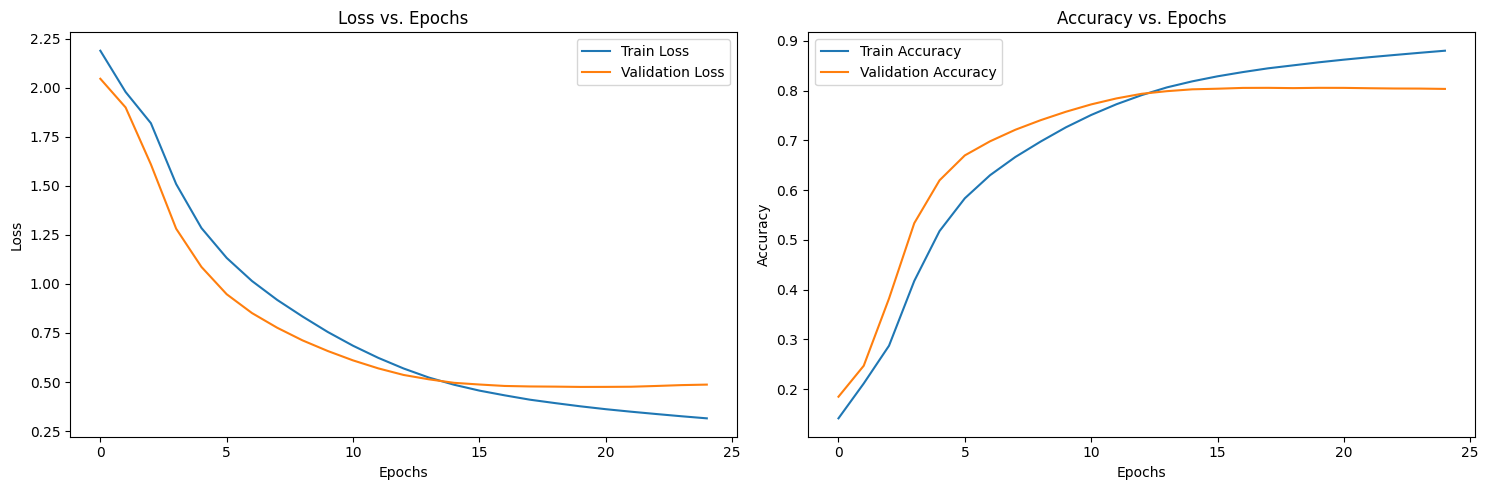

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plot for Loss
axes[0].plot(train_losses, label='Train Loss')
axes[0].plot(val_losses, label='Validation Loss')
axes[0].set_title('Loss vs. Epochs')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plot for Accuracy
axes[1].plot(train_accuracies, label='Train Accuracy')
axes[1].plot(val_accuracies, label='Validation Accuracy')
axes[1].set_title('Accuracy vs. Epochs')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()


## Testing with CNN

In [8]:
#This testset is also prepared in data preparation notebook. 
import pandas as pd
test=pd.read_csv(r"C:\Semester 2\ANN\Portfolio2\Prepared_datasets\testing_df.csv")
test

,test
0,9027008137614000250800000706070950009106000542...
1,0708010200207300001060920040900754800520080038...
2,0009001650806000306012437008070950230307046009...
3,1580096070000760027264183000157040000040800510...
4,0020500096038002059700008361080005032060350800...
...,...
9995,0001050300407062100009405607510943060202507040...
9996,1058000404001300056030509170006005315060030092...
9997,0000278000703000900487500367800000040524009783...
9998,0020950000391800001050020980017200803275009164...


In [9]:
def preprocess_puzzle(puzzle_str):
    """
    Preprocess the input Sudoku puzzle string into a format suitable for the model.
    """
    puzzle_tensor = torch.tensor([int(p) for p in puzzle_str], dtype=torch.float32).reshape(1, 1, 9, 9) / 9 - 0.5
    return puzzle_tensor.to(device)

def predict_test_set(model, test_df):
    """
    Predict solutions for all puzzles in the test DataFrame.
    """
    model.eval()
    predictions = []

    for _, row in test_df.iterrows():
        puzzle_str = row['test']
        with torch.no_grad():
            puzzle_tensor = preprocess_puzzle(puzzle_str)
            output = model(puzzle_tensor)
            solution = output.argmax(dim=1).view(9, 9) + 1  # Convert predictions to 1-based indexing
            predictions.append(solution.cpu().numpy())

    return predictions

In [10]:
# predict on the entire test set
predicted_solutions = predict_test_set(model, test)

In [11]:
indexes = []
labels= []
for i,j in enumerate(predicted_solutions):
    preds = j.reshape(9,9)
    for row in range(0,9):
        for col in range(0,9):
            index = str(i)+"_"+str(row)+str(col)
            indexes.append(index)
            labels.append(preds[row,col])

In [12]:
CNN_Test_Predictions =  {"id":indexes , "values":labels}
CNN_Test_Predictions = pd.DataFrame(CNN_Test_Predictions)
CNN_Test_Predictions.to_csv("CNN_Test_Predictions.csv", index=False)
print('saved')

saved


# Approach - 2: LSTM

In [13]:
class SudokuDataset(Dataset):
    def __init__(self, dataframe, subset="train"):
        self.dataframe = dataframe
        self.subset = subset

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Get puzzle and solution strings
        puzzle_str = self.dataframe.iloc[idx, 0]
        solution_str = self.dataframe.iloc[idx, 1]

        # Convert strings to list of integers
        puzzle = [int(p) for p in puzzle_str]
        solution = [int(s) for s in solution_str]

        # Convert lists to tensors
        puzzle_tensor = torch.tensor(puzzle, dtype=torch.float32) / 9.0 - 0.5
        solution_tensor = torch.tensor(solution, dtype=torch.int64) - 1
        return puzzle_tensor, solution_tensor

In [14]:
class SudokuSolverLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=3):
        super(SudokuSolverLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True,bidirectional=True)
        self.lstm2 = nn.LSTM(2*hidden_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.lstm3 = nn.LSTM(2*hidden_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(2*hidden_size, 9)  # Output: 9 possible digits

    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)  # 2 for bidirection
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate through LSTM layers
        out, _ = self.lstm1(x.view(x.size(0), -1, self.input_size), (h0, c0))
        out, _ = self.lstm2(out)
        out, _ = self.lstm3(out)

        # Reshape output for the fully connected layer
        out = out.contiguous().view(-1, 2*self.hidden_size)  # 2 for bidirection
        out = self.fc(out)  # Fully connected layer

        # Reshape to have batch_size sequences of length 81
        out = out.view(x.size(0), 81, -1)
        
        return out

In [15]:
def train_model_lstm(model, train_loader, val_loader, epochs, criterion, optimizer, device):
    # Lists to store metrics
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        total_train = 0

        for puzzles, solutions in train_loader:
            puzzles, solutions = puzzles.to(device), solutions.to(device).view(-1)
            optimizer.zero_grad()
            outputs = model(puzzles).view(-1, 9)
            loss = criterion(outputs, solutions)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, -1)
            train_correct += (predicted == solutions.view(-1)).sum().item()
            total_train += solutions.numel()

        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = train_correct / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss = 0.0
        val_correct = 0
        total_val = 0

        with torch.no_grad():
            for puzzles, solutions in val_loader:
                puzzles, solutions = puzzles.to(device), solutions.to(device).view(-1)
                outputs = model(puzzles).view(-1, 9)
                loss = criterion(outputs, solutions).item()
                val_loss += loss
                _, predicted = torch.max(outputs.data, -1)
                val_correct += (predicted == solutions.view(-1)).sum().item()
                total_val += solutions.numel()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = val_correct / total_val
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch + 1}: '
              f'Train Loss: {avg_train_loss:.4f}, '
              f'Train Accuracy: {train_accuracy:.4f}, '
              f'Validation Loss: {avg_val_loss:.4f}, '
              f'Validation Accuracy: {val_accuracy:.4f}')
    
    return train_losses, train_accuracies, val_losses, val_accuracies

In [16]:
# Initialization and training
model_lstm = SudokuSolverLSTM().to(device)
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
epochs=18
train_losses, train_accuracies, val_losses, val_accuracies = train_model_lstm(model_lstm, train_loader, val_loader, epochs, criterion, optimizer, device)

Epoch 1: Train Loss: 2.1973, Train Accuracy: 0.1113, Validation Loss: 2.1972, Validation Accuracy: 0.1108
Epoch 2: Train Loss: 2.1972, Train Accuracy: 0.1115, Validation Loss: 2.1972, Validation Accuracy: 0.1114
Epoch 3: Train Loss: 2.1972, Train Accuracy: 0.1117, Validation Loss: 2.1972, Validation Accuracy: 0.1113
Epoch 4: Train Loss: 2.1944, Train Accuracy: 0.1193, Validation Loss: 2.1829, Validation Accuracy: 0.1338
Epoch 5: Train Loss: 2.1164, Train Accuracy: 0.1641, Validation Loss: 1.9275, Validation Accuracy: 0.3423
Epoch 6: Train Loss: 1.7121, Train Accuracy: 0.3990, Validation Loss: 1.5143, Validation Accuracy: 0.5219
Epoch 7: Train Loss: 1.3962, Train Accuracy: 0.5269, Validation Loss: 1.3005, Validation Accuracy: 0.5642
Epoch 8: Train Loss: 1.2354, Train Accuracy: 0.5702, Validation Loss: 1.1835, Validation Accuracy: 0.5826
Epoch 9: Train Loss: 1.1515, Train Accuracy: 0.5847, Validation Loss: 1.1244, Validation Accuracy: 0.5892
Epoch 10: Train Loss: 1.1071, Train Accuracy: 

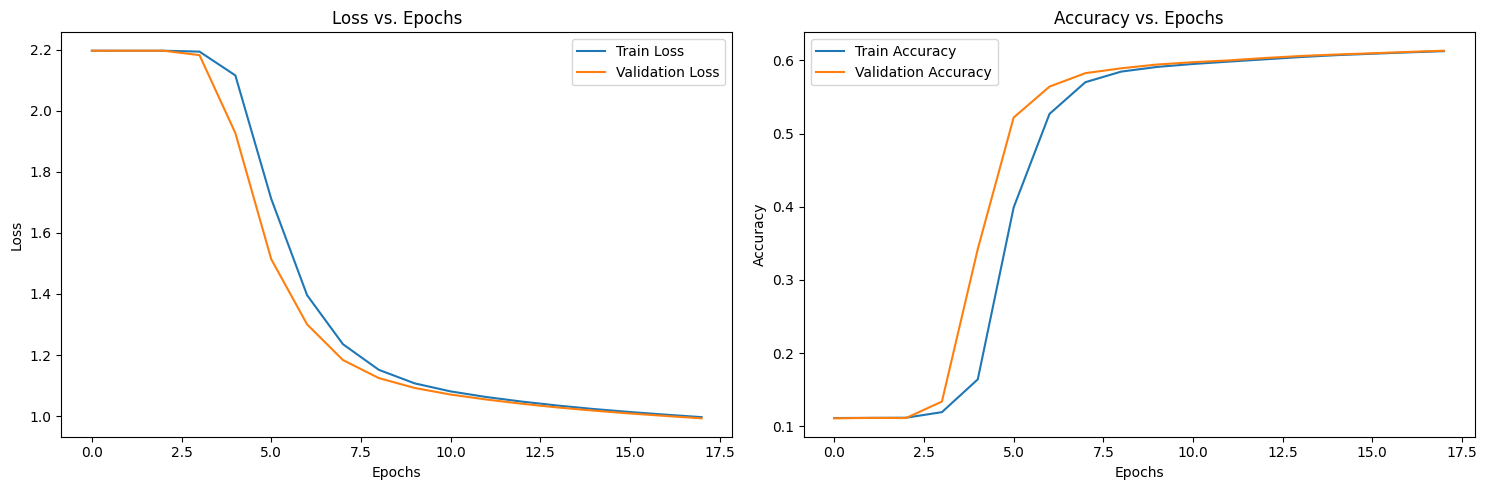

In [17]:
# Plotting
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plot for Loss
axes[0].plot(train_losses, label='Train Loss')
axes[0].plot(val_losses, label='Validation Loss')
axes[0].set_title('Loss vs. Epochs')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plot for Accuracy
axes[1].plot(train_accuracies, label='Train Accuracy')
axes[1].plot(val_accuracies, label='Validation Accuracy')
axes[1].set_title('Accuracy vs. Epochs')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

### Testing with LSTM

In [18]:
def preprocess_puzzle_lstm(puzzle_str):
    """
    Preprocess the input Sudoku puzzle string into a format suitable for the LSTM model.
    """
    # Convert string to list of integers and normalize the values
    puzzle = [int(p) for p in puzzle_str]
    puzzle_tensor = torch.tensor(puzzle, dtype=torch.float32) / 9.0 - 0.5
    puzzle_tensor = puzzle_tensor.view(1, -1, 1)  # Reshape for the LSTM: (batch_size, sequence_length, input_size)
    return puzzle_tensor.to(device)

def predict_test_set_lstm(model, test_df):
    """
    Predict solutions for all puzzles in the test DataFrame using the LSTM model.
    """
    model.eval()
    predictions = []

    # Use iterrows to iterate over the DataFrame
    for _, row in test_df.iterrows():
        puzzle_str = row['test']
        with torch.no_grad():
            puzzle_tensor = preprocess_puzzle_lstm(puzzle_str)
            output = model(puzzle_tensor)
            # The LSTM model outputs a sequence, so we reshape the prediction to the desired 9x9 Sudoku grid
            solution = output.argmax(dim=2).view(9, 9) + 1  # Convert predictions to 1-based indexing
            predictions.append(solution.cpu().numpy())

    return predictions

# Predict on the entire test set using the LSTM model
predicted_solutions_lstm = predict_test_set_lstm(model_lstm, test)

# Convert the predictions to the required format
indexes = []
labels = []
for i, solution in enumerate(predicted_solutions_lstm):
    for row in range(9):
        for col in range(9):
            index = f"{i}_{row}{col}"
            indexes.append(index)
            labels.append(solution[row, col])

# Create the DataFrame
Test_Predictions_lstm = pd.DataFrame({
    "id": indexes,
    "values": labels
})

Test_Predictions_lstm.to_csv("Test_Predictions_lstm.csv", index=False)
print('saved')

saved


#### Conclusion:

1. Training With 50000 Games:

    With CNN  - 81% Kaggle Accuracy
    
    with LSTM - 64% Kaggle Accuarcy

2. Training with 1 Million Games:

    With CNN - 84% Kaggle Accuracy
    
    With LSTM - 74% Kaggle Accuracy

3. Training with 9 Million Games:

    With CNN - **94%** Kaggle Accuracy
    
    With LSTM - 82% Kaggle Accuracy

Finally I Got 94% in kaggle for Task 2. This notebook is only having training with 50000 Games. 

**Name: THARUN KUMAR KORINE PALLI**

**Matriculation Number: 5123708**

**Email: tharunkumar.korinepalli@study.thws.de**

# <center>THE END</center>